### Battery Classification: Random Forest Classification for Multi-Class Chemistry Classification


In this notebook we will explore a random forest classification method to predict different chemistries based on the input training features.

In [12]:
# Import packages 
import os 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import LeaveOneOut, RandomizedSearchCV

# Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt


Now we'll load the dataset for model training, since we've demonstrated this in the prior notebook, we'll copy over the relavent code in the cell below....

In [13]:

def summarize_features(input_df, chemistry, chemistry_filepath, desired_features):
    """This function takes the input_features and finds the mean, min, max and standard deviation for each of them,
    returning a dataframe of the aggregated features for each unique battery, along with its chemistry. 
    Inputs: input_df (pandas dataframe), chemistry (str), chemistry_filepath (str), and desired_features (list)
    Outputs: agg_data (pandas dataframe)"""

    tdf = input_df[desired_features]

    agg_data = {}
    for col in tdf.columns:
        agg_data[f"{col}_mean"] = tdf[col].mean()
        agg_data[f"{col}_std"] = tdf[col].std()
        agg_data[f"{col}_min"] = tdf[col].min()
        agg_data[f"{col}_max"] = tdf[col].max()
    
    # Add metadata
    agg_data["chemistry"] = chemistry
    agg_data["file"] = chemistry_filepath
    return agg_data


def agg_chem_features(input_dir): 
    """This function walks through an input directory, finds each chemistry folder and the battery id 
    folders embedded in each of them. For each battery ID, it reads the file to a dataframe and 
    aggregates the desired features using summarize features.  
    Inputs: input_dir (str)
    Outputs: result_df (pandas dataframe)"""

    chemistries = os.listdir(input_dir)
    desired_features = ["cycle_index","normalized_time","voltage_v", "c_rate","temperature_k"]
    all_data = []
    for chemistry in chemistries:
        chemistry_path = os.path.join(input_dir, chemistry)
        for chemistry_folder in os.listdir(chemistry_path):
            chemistry_filepath = os.path.join(chemistry_path, chemistry_folder)
            chemistry_filepath_dir = os.listdir(chemistry_filepath)
            desired_files = [temp_file for temp_file in chemistry_filepath_dir if "error_log" not in temp_file]
            
            charge_filepath = None
            discharge_filepath = None

            for file in desired_files: 
                if "discharge" in file:
                    discharge_filepath = os.path.join(chemistry_filepath, file)
                elif "charge" in file: 
                    charge_filepath = os.path.join(chemistry_filepath, file)
                    
            # Only proceed if both files were found
            if not (charge_filepath and discharge_filepath):
                continue
                
            # Read the file for charge and discharge 
            charge_df = pd.read_csv(charge_filepath)
            discharge_df = pd.read_csv(discharge_filepath)
            if len(charge_df) > 0 and len(discharge_df)>0: 
                if charge_df.c_rate.iloc[0] == "variable" or discharge_df.c_rate.iloc[0] == "variable": 
                    continue 
                else: 
                    charge_data = summarize_features(charge_df, chemistry, charge_filepath, desired_features)
                    discharge_data = summarize_features(discharge_df, chemistry, discharge_filepath, desired_features)

                    # Convert dicts to DataFrames for concat
                    charge_data = pd.DataFrame([charge_data])
                    discharge_data = pd.DataFrame([discharge_data])

                    # Add column naming to distinguish between charge and discharge
                    charge_data.columns = ['charge_' + col if col not in ['chemistry', 'file'] else col for col in charge_data.columns]
                    discharge_data.columns = ['discharge_' + col if col not in ['chemistry', 'file'] else col for col in discharge_data.columns]

                    combined_df = pd.concat([charge_data, discharge_data], axis=1)  # ✅ axis=1 to combine horizontally
                    all_data.append(combined_df)
    
    # Combine all per-file aggregates
    result_df = pd.concat(all_data, ignore_index=True)  # ✅ concat instead of DataFrame(list_of_dfs)
    return result_df


def scrub_values(input_df): 
    """This function takes the input dataframe and removes any features from the dataframe if they are found 
     in the pre-specified strip_cols list, ultimately returning the subset feature dataframe.  
    Inputs: input_df (pandas dataframe)
    Outputs: strip_df (pandas dataframe)"""

    #Now let's remove unneeded features: 
    strip_cols = ['charge_cycle_index_min', 'charge_cycle_index_max', 'charge_cycle_index_mean', 'charge_cycle_index_std',
                'charge_normalized_time_min', 'charge_normalized_time_max', 'discharge_c_rate_min', 'discharge_c_rate_max',
                'discharge_c_rate_std', 'charge_c_rate_min', 'charge_c_rate_max', 'charge_c_rate_std', 
                'discharge_temperature_k_max', 'discharge_temperature_k_min', 'discharge_temperature_k_std',
                'charge_temperature_k_max', 'charge_temperature_k_min', 'charge_temperature_k_std', 
                'discharge_temperature_k_mean', 'file', 'discharge_cycle_index_mean', 'discharge_cycle_index_max',
                'discharge_cycle_index_min', 'discharge_cycle_index_std',
                'discharge_normalized_time_max', 'discharge_normalized_time_min', 'discharge_normalized_time_std',
                'charge_normalized_time_std', 'charge_normalized_time_mean', 'discharge_normalized_time_mean']

    strip_df = input_df.drop(columns=strip_cols, errors='ignore')
    strip_df = strip_df.iloc[:, :-1]
    strip_df.describe()
    return strip_df


input_dir = r'..\assets\processed'
print('Generating initial training data')
result_df = agg_chem_features(input_dir)
print('Removing unwanted features')
strip_df = scrub_values(result_df)
print('Here is a quick overview:')
strip_df.sample(3)



Generating initial training data
Removing unwanted features
Here is a quick overview:


,charge_voltage_v_mean,charge_voltage_v_std,charge_voltage_v_min,charge_voltage_v_max,charge_c_rate_mean,charge_temperature_k_mean,chemistry,discharge_voltage_v_mean,discharge_voltage_v_std,discharge_voltage_v_min,discharge_voltage_v_max,discharge_c_rate_mean
67,3.517332,0.085568,3.293500,3.600446,1.0000,298.00,LFP,2.788004,0.484907,1.996997,3.589800,1.0000
13,3.977979,0.114877,3.604022,4.194094,0.5000,298.00,LCO,3.558422,0.230187,2.699568,4.071061,0.5000
194,4.047912,0.199124,3.485504,4.200214,1.5125,278.15,NCA,3.256550,0.365307,2.499966,4.135231,1.5125


Now we'll separate between betweeen input and output feaures, we'll train the model, and compare the confusion matrix

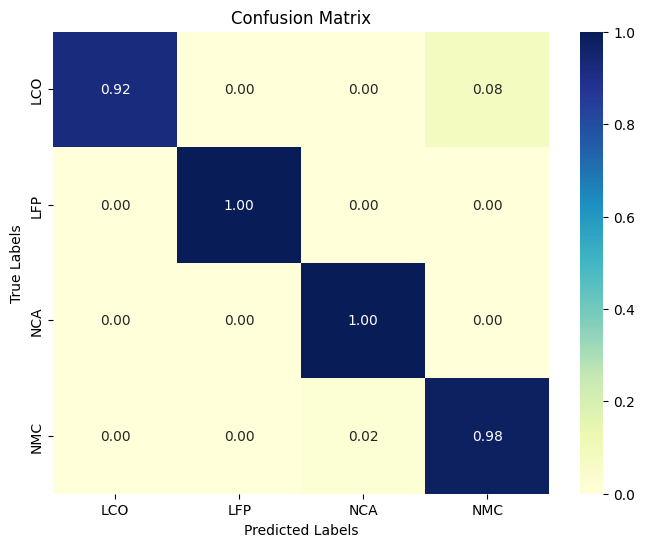

Classification Report:
              precision    recall  f1-score   support

         LCO       1.00      0.92      0.96        13
         LFP       1.00      1.00      1.00        58
         NCA       0.71      1.00      0.83         5
         NMC       0.99      0.98      0.98        90

    accuracy                           0.98       166
   macro avg       0.93      0.98      0.94       166
weighted avg       0.99      0.98      0.98       166



In [14]:
# Split between outcome and input variables
training_column = "chemistry"
y = strip_df[training_column]
X = strip_df.drop(columns=[training_column])

# Separate between train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42
)

# Prepare the encoder
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# ---- Replace Logistic Regression with Random Forest ----
model = RandomForestClassifier(
    n_estimators=300,        # number of trees
    max_depth=None,         # let the trees grow fully
    class_weight="balanced",# good for imbalanced classes
    random_state=42
)
model.fit(X_train, y_train_encoded)
# ---------------------------------------------------------

# Predictions
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, predictions, normalize='true')

# Optional: get the class labels (in the same order used by LabelEncoder)
labels = encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test_encoded, predictions, target_names=labels))


We can see the Random Forest Classifier performs much better than either the logistic regression classifier the pca-transformed k-means clustering algorithm. We'll apply hyperparameter tuning with leave-one-out cross-validation, and then check model size, before assessing the alternative neural network based approaches. 

Running LOO hyperparameter tuning (this may take a while)…
Best parameters found: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}
Best LOO accuracy: 0.961038961038961


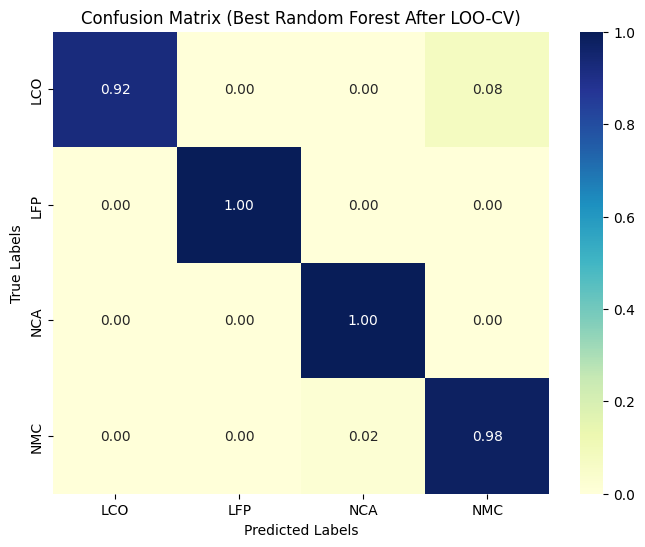


Classification Report:
              precision    recall  f1-score   support

         LCO       1.00      0.92      0.96        13
         LFP       1.00      1.00      1.00        58
         NCA       0.71      1.00      0.83         5
         NMC       0.99      0.98      0.98        90

    accuracy                           0.98       166
   macro avg       0.93      0.98      0.94       166
weighted avg       0.99      0.98      0.98       166



In [15]:
loo = LeaveOneOut()

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 4],
    "min_samples_leaf": [1, 2]
}

rf = RandomForestClassifier(class_weight="balanced", random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,
    cv=loo,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)


print("Running LOO hyperparameter tuning (this may take a while)…")
random_search.fit(X_train, y_train_encoded)

print("Best parameters found:", random_search.best_params_)
print("Best LOO accuracy:", random_search.best_score_)

# Refit best model
best_model = random_search.best_estimator_

# Evaluate on Test
predictions = best_model.predict(X_test)
probabilities = best_model.predict_proba(X_test)
cm = confusion_matrix(y_test_encoded, predictions, normalize='true')
labels = encoder.classes_

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix (Best Random Forest After LOO-CV)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test_encoded, predictions, target_names=labels))

No real improvement here, but the model still seems to achieve all our desired performance metrics. Let's check the size of the model to review the business implications for deploying the model on AWS, and later releasing on physical hardware. 

In [16]:
# Export the model and check size: 
import pickle

with open('logistic_model.pkl', 'wb') as f:
    pickle.dump(model, f)

file_path = 'logistic_model.pkl'  # or 'logistic_model.pkl'
size_bytes = os.path.getsize(file_path)
size_kb = size_bytes / 1024
size_mb = size_kb / 1024

print(f"Model size: {size_bytes} bytes ({size_kb:.2f} KB / {size_mb:.2f} MB)")
os.remove(file_path)
print(f"File '{file_path}' has been deleted.")

Model size: 888084 bytes (867.27 KB / 0.85 MB)
File 'logistic_model.pkl' has been deleted.


While the model has the performance characteristics that we'd desire, the model size is about 4x larger than we'd want for deployment on a simple micro-controller. We'll explore a couple more methods to see how both performance and compute compares.... 